### <center>CHEST X-RAY - PNEUMONIA</center>

Problem Statement - The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification (opaque/cloudy) in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ !

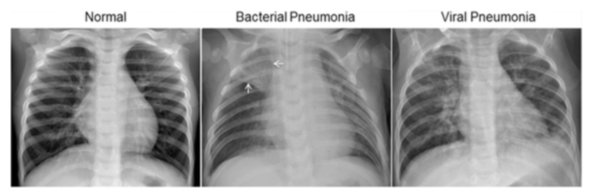

More details about dataset - https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

---
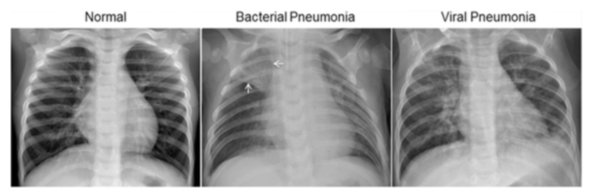

In [1]:
!python --version

Python 3.10.14


In [2]:
# Importing Libraries
import numpy
import os
import random
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import cv2 as cv
from keras import backend as bknd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPool2D, Flatten, Dense, Dropout

warnings.filterwarnings("ignore")

In [3]:
# base dir
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'

train_dir = base_dir + '/train'
val_dir = base_dir + '/val'
test_dir = base_dir + '/test'

normal_case_train = train_dir + '/NORMAL'
pneumonia_case_train = train_dir + '/PNEUMONIA'

In [4]:
os.listdir(base_dir)

['chest_xray', '__MACOSX', 'val', 'test', 'train']

Random normal images : 
NORMAL2-IM-0671-0001.jpeg
Image size :  (1546, 1205, 3)
NORMAL2-IM-1020-0001-0001.jpeg
Image size :  (1886, 1357, 3)
IM-0619-0001.jpeg
Image size :  (1554, 1345, 3)


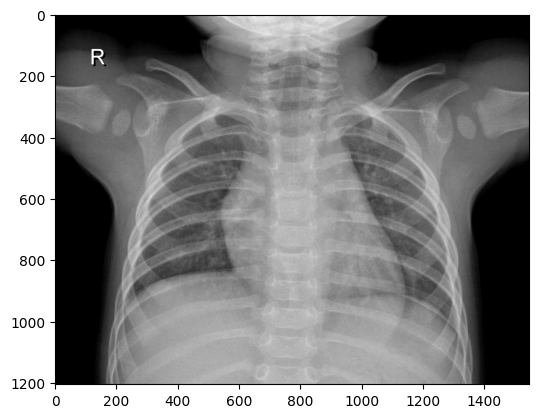

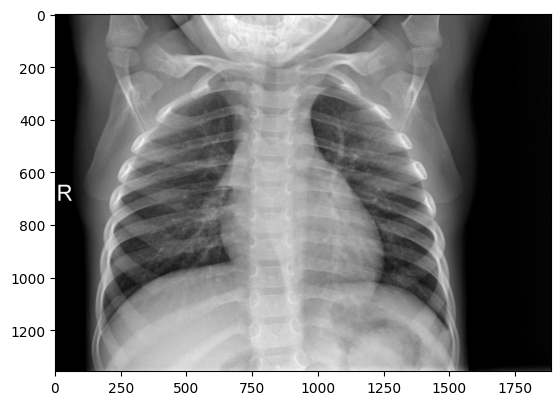

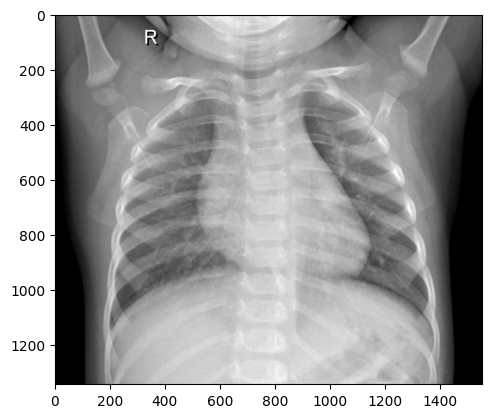

In [5]:
# Read random training image
print("Random normal images : ")

for _ in range(3):
    random_img = random.choice(os.listdir(normal_case_train))
    print(random_img)
    img_path = os.path.join(normal_case_train, random_img)
    img_sample = cv.imread(img_path)
    height, width, channels = img_sample.shape
    print("Image size : ",(width, height, channels))
    plt.figure()
    plt.imshow(img_sample)

Text(0.5, 1.0, 'Count of Positive (0) and Negative Cases (1)')

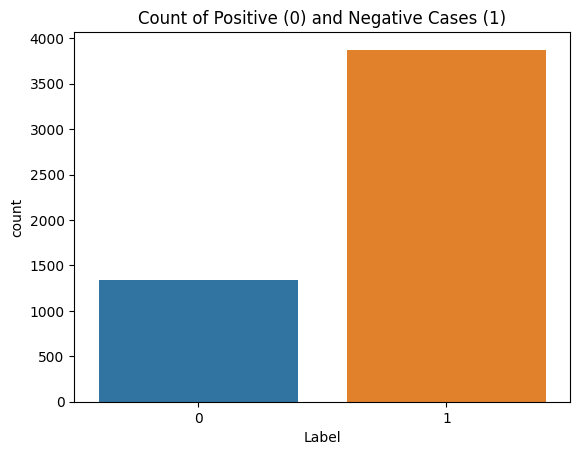

In [6]:
# Count Plot for both classes [NORMAL & PNEUMONIA] 
# Creating DataFrame 
train_df = []

# Assigning 0 to normal case
for img in os.listdir(normal_case_train):
    
    train_df.append((img, 0))
    
for img in os.listdir(pneumonia_case_train):
    
    train_df.append((img, 1))
    
train_df = pd.DataFrame(train_df, columns=['Image', 'Label'], index = None)

# Random shuffling complete dataset
train_df = train_df.sample(frac=1).reset_index(drop=True)

cnt_plt = sns.countplot(data=train_df, x='Label', order=[0, 1]) 

cnt_plt.set_title("Count of Positive (0) and Negative Cases (1)")

There is imbalance in data, the number of Pneumonia case are more as compared to normal cases.

In [7]:
train_df.shape

(5216, 2)

In [8]:
# Data Augumentation
img_width, img_height = 250, 250
batch_size=20
epochs = 50
nb_train_samples = 5000
nb_val_samples = 1000

# Image shape
if bknd.image_data_format == "channels_first":

    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range = 0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range = 0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Apply on data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_width, img_height),
                                                    batch_size=batch_size,class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir, target_size=(img_width, img_height),
                                                    batch_size=batch_size,class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(img_width, img_height),
                                                    batch_size=batch_size,class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Model Building

In [9]:
# Model Building
"""
Steps:
1. Initializing the ConvNet
2. Define by adding layers
3. Compiling the model
4. Fit/Train model
"""
# Initialize model
model = Sequential()

# Defining model
model.add(Conv2D(32, kernel_size=(3,3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 248, 248, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 122, 122, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,444,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,473,505 (13.25 MB)

 Trainable params: 3,473,505 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history = model.fit(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs,
validation_data=val_generator, validation_steps=nb_val_samples//batch_size)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.7560 - loss: 0.5136 - val_accuracy: 0.6875 - val_loss: 0.8676
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8345 - loss: 0.3987 - val_accuracy: 0.8125 - val_loss: 0.9446
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 251s 987ms/step - accuracy: 0.8785 - loss: 0.3188 - val_accuracy: 0.6250 - val_loss: 1.8647
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8411 - loss: 0.3162 - val_accuracy: 0.6250 - val_loss: 1.0425
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 250s 987ms/step - accuracy: 0.8755 - loss: 0.2994 - val_accuracy: 0.7500 - val_loss: 1.1070
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8895 - loss: 0.2559 - val_accuracy: 0.5625 - val_loss: 1.4274
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 250s 987ms/step - accuracy: 0.9041 - loss: 0.2616 - val_accuracy: 0.6875 - val_loss: 1.2745
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8821 - loss: 0.27

In [12]:
test_accuracy = model.evaluate(test_generator)

print("The accuracy on test set : ", test_accuracy[1] * 100)

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 412ms/step - accuracy: 0.8772 - loss: 0.5244
The accuracy on test set :  87.82051205635071


If you liked this Notebook, please do upvote.

If you have any suggestions or questions, feel free to comment!

To be continued....